In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_s_curve, make_swiss_roll
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq


In [2]:

from google.colab import drive

drive.mount('/content/drive')

%cd /content/drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


In [3]:

from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


### 1.1 IMS dataset
This time we will adopt the real dataset. The experiment will used the IMS dataset and also the phm2012 dataset.
First we will consider the IMS dataset, specifically the No.2 dataset No. 3 bearing (channel).


The test rig can be seen below:


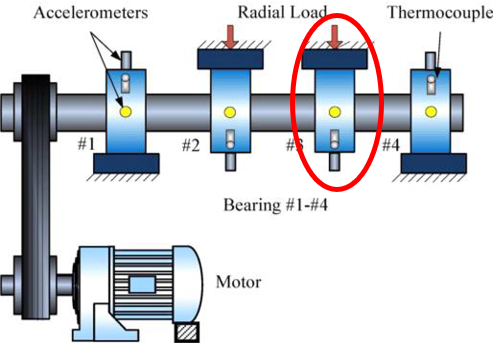



### Training the model using the time-domain data

In [4]:
import scipy.io as scio
from sklearn.model_selection import train_test_split
import pandas as pd
dict_ = scio.loadmat('AE_Diffusion/AE_data_ims/N2_data_C3_.mat')
data_ = dict_['data_c3_']
def normalize(data):
    data_ = (data-np.min(data))/(np.max(data)-np.min(data))
    return data_
data_h = np.random.randn(1000,4,1024)
data_1 = np.random.randn(4920,4,1024)
ii = 0
for i in range(4920):
  for j in range(4):
    data_1[i,j,:] = normalize(data_[i,1024*j:1024*(j+1)])
    # print(ii)
data_h = data_1[0:1000,:,:]


In [5]:
data_b = data_1[4000:4920,:,:]
data_tv = np.concatenate((data_h, data_b),axis = 0)
# data_test  = data_1[1000:-1,:,:]
yh = np.zeros(1000)
yu = np.ones(920)
y_ = np.concatenate((yh,yu))
data_tr,data_va,y_1,y_v = train_test_split(data_tv, y_, test_size=0.2, random_state=42)

batch_size = 16 #考虑到样本总数仅为1000个,batch_size设定为64个
# dataset放到dataloader中
dataset_tensor = torch.utils.data.TensorDataset(torch.tensor(data_tr,dtype=torch.float32).cuda(),torch.tensor(y_1,dtype = torch.float32).cuda())
#dataloader_1 = torch.utils.data.DataLoader(torch.tensor(data_tr,dtype=torch.float32).cuda(), batch_size=batch_size, shuffle=True)
dataloader_1 = torch.utils.data.DataLoader(dataset_tensor,batch_size=batch_size, shuffle=True)



### Training the model using the frequency domain data

In [6]:
# import scipy.io as scio
# from sklearn.model_selection import train_test_split
# import pandas as pd
# dict_ = scio.loadmat('AE_Diffusion/AE_data_ims/data_f.mat')
# data_ = dict_['data_f']
# def normalize(data):
#     data_ = (data-np.min(data))/(np.max(data)-np.min(data))
#     return data_
# data_h = np.random.randn(1000,1,2048)
# data_1 = np.random.randn(4920,1,2048)
# ii = 0
# for i in range(4920):
#   for j in range(1):
#     data_1[ii,j,:] = normalize(data_[i,2048*j:2048*(j+1)])
#     ii = ii + 1
#     # print(ii)
# data_h = data_1[0:1000,:,:]

In [7]:
# data_b = data_1[4500:4750,:,:]
# data_tv = np.concatenate((data_h, data_b),axis = 0)
# # data_test  = data_1[1000:-1,:,:]
# yh = np.zeros(1000)
# yu = np.ones(250)
# y_ = np.concatenate((yh,yu))
# data_tr,data_va,y_1,y_v = train_test_split(data_tv, y_, test_size=0.2, random_state=42)

# batch_size = 16 #考虑到样本总数仅为1000个,batch_size设定为64个
# # dataset放到dataloader中
# dataset_tensor = torch.utils.data.TensorDataset(torch.tensor(data_tr,dtype=torch.float32).cuda(),torch.tensor(y_1,dtype = torch.float32).cuda())
# #dataloader_1 = torch.utils.data.DataLoader(torch.tensor(data_tr,dtype=torch.float32).cuda(), batch_size=batch_size, shuffle=True)
# dataloader_1 = torch.utils.data.DataLoader(dataset_tensor,batch_size=batch_size, shuffle=True)



### 2. Noise strategy
I adopt the linear noise strategy.

In [8]:
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

In [9]:

num_steps = 1000
#指定每一步的beta的具体数值
# betas = torch.linspace(-6,6,num_steps)
# betas = torch.sigmoid(betas)*(0.5e-2-1e-5)+1e-5
betas = linear_beta_schedule(num_steps)
# betas = quadratic_beta_schedule(num_steps)
# betas = torch.linspace(-0.0001,0.02, num_steps)
alphas = 1-betas


In [10]:
alphas_prod = torch.cumprod(alphas,0)
alphas_prod_p = torch.cat([torch.tensor([1]),alphas_prod[:-1]],0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
#之后公式中需要使用的log(1-alpha_p)
one_minus_alphas_bar_log = torch.log(1-alphas_prod)
#之后公式中需要使用的sqrt(1-alpha_p)
one_minus_alphas_bar_sqrt = torch.sqrt(1-alphas_prod)


In [11]:
assert alphas.shape==alphas_prod.shape==alphas_prod_p.shape==\
alphas_bar_sqrt.shape==one_minus_alphas_bar_log.shape\
==one_minus_alphas_bar_sqrt.shape
print("all the same shape",betas.shape)

all the same shape torch.Size([1000])


3. Forward process function

In [12]:
def q_x(x_0, t):
    """可以基于x[0]得到任意时刻t的x[t]"""
    #生成正态分布采样
    noise = torch.randn_like(x_0)
    #得到均值方差
    alphas_t = alphas_bar_sqrt[t]
    alphas_1_m_t = one_minus_alphas_bar_sqrt[t]
    #根据x0求xt
    return (alphas_t * x_0 + alphas_1_m_t * noise)  # 在x[0]的基础上添加噪声


### 4. Network structure Based on the encoder of the Transformer structure.
I tried different structures and make ablation experiments to simplify the network structure to generate the high-fidelity samples and also meanwhile cancel some unnecessary part to save training time.

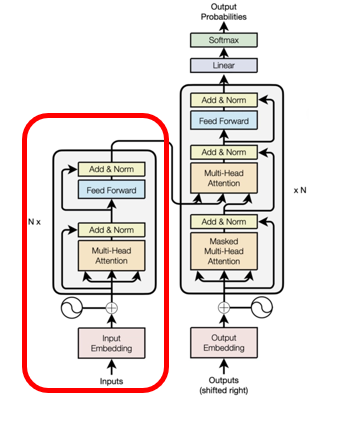




### Non-conditional and Non-guidance version
This is the old version of the classifier guidance, which does not really work well on the bearing simulation signal.

> 缩进块



In [13]:
# import torch
# import torch.nn.functional as F
# from torch import nn


# class CustomModel(nn.Module):
#     def __init__(self, n_steps, input_size, hidden_size, num_heads):
#         super(CustomModel, self).__init__()

#         # Linear layer after input
#         self.linear1 = nn.Linear(input_size, hidden_size)

#         # Multi-head attention layer
#         self.multihead_attention1 = nn.MultiheadAttention(hidden_size, num_heads)

#         # Linear layer after multi-head attention
#         self.linear2 = nn.Sequential(
#             nn.Linear(hidden_size, input_size),
#             # nn.BatchNorm1d(5),
#             #nn.ReLU()
#             nn.SiLU()
#             )

#         self.step_embeddings1 = nn.Embedding(n_steps,input_size)
#         self.step_embeddings2 = nn.Embedding(n_steps,input_size)
#         self.step_embeddings3 = nn.Embedding(n_steps,input_size)

#         self.Layernorm_ = nn.LayerNorm(512)

#     def forward(self, x, t):
#         # Apply the first linear layer
#         b_s = x.shape[0]
#         seq_len = x.shape[1]
#         t_ = t*torch.ones(1,seq_len).type(torch.int).cuda()
#         x0 = x
#         # x = self.linear1(x)
#         # Transpose x to have shape (seq_len, batch_size, input_size)
#         x = x.permute(1, 0, 2)
#         # Apply multi-head attention
#         x, _ = self.multihead_attention1(x, x, x)
#         x = x.permute(1, 0, 2)
#         x = x + self.step_embeddings1(t_)
#         x = x + x0
#         x = self.Layernorm_(x)

#         x1 = x
#         x = self.linear2(x)
#         x = x + self.step_embeddings2(t_)
#         x = x+x1
#         x = self.Layernorm_(x)
#         return x




### introduce the conditional mechanism
Here we introduce the classifier free guidance, which did not really train a classifier. Instead, the condition is taken into consideration as a random variable during the training process.

In [14]:
import torch
import torch.nn.functional as F
from torch import nn


class CustomModel(nn.Module):
    def __init__(self, n_steps, input_size, hidden_size, num_heads):
        super(CustomModel, self).__init__()

        # Linear layer after input
        self.linear1 = nn.Linear(input_size, hidden_size)

        # Multi-head attention layer
        self.multihead_attention1 = nn.MultiheadAttention(hidden_size, num_heads)

        # Linear layer after multi-head attention
        self.linear2 = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            # nn.BatchNorm1d(5),
            #nn.ReLU()
            nn.SiLU()
            )

        self.step_embeddings1 = nn.Embedding(n_steps,input_size)
        self.step_embeddings2 = nn.Embedding(n_steps,input_size)
        self.step_embeddings3 = nn.Embedding(n_steps,input_size)

        self.y_embeddings1 = nn.Embedding(2,input_size)
        self.y_embeddings2 = nn.Embedding(2,input_size)
        self.y_embeddings3 = nn.Embedding(2,input_size) # the first dimension is set as 2 because there are two labels in this case


        self.Layernorm_ = nn.LayerNorm(input_size)

    def forward(self, x, t , y = None, uncon_rate = 0.1):
        unconditional = torch.rand(1)<=uncon_rate
        # Apply the first linear layer
        b_s = x.shape[0]
        seq_len = x.shape[1]
        t_ = t*torch.ones(1,seq_len).type(torch.int).cuda()
        #y_ = y*torch.ones(1,seq_len).type(torch.int).cuda()

        x0 = x
        # x = self.linear1(x)
        # Transpose x to have shape (seq_len, batch_size, input_size)
        x = x.permute(1, 0, 2)
        # Apply multi-head attention
        x, _ = self.multihead_attention1(x, x, x)
        x = x.permute(1, 0, 2)
        if not unconditional and y is not None:
          y_ = torch.tensor(y,dtype=torch.int).view(-1,1).cuda()
          x = x + self.y_embeddings1(y_)
        x = x + self.step_embeddings1(t_)
        x = x + x0
        x = self.Layernorm_(x)

        x1 = x
        x = self.linear2(x)
        if not unconditional and y is not None:
          x = x + self.y_embeddings2(y_)
        x = x + self.step_embeddings2(t_)
        x = x+x1
        x = self.Layernorm_(x)
        return x




In [15]:
# class TimeEmbedding(nn.Module):
#     def __init__(self, input_size, output_size):
#         super(TimeEmbedding, self).__init__()
#         self.embedding = nn.Embedding(input_size, output_size)

#     def forward(self, time_indices):
#         embedded_time = self.embedding(time_indices)
#         return embedded_time

# class Residual(nn.Module):
#   def __init__(self,fn):
#     super().__init__()
#     self.fn = fn
#   def forward(self,x,**kwargs):
#     out = self.fn(x) + x
#     return out

# class FeedForward(nn.Module):
#     def __init__(self, dim, hidden_dim,  dropout = 0.):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(dim, hidden_dim),
#             nn.GELU(),
#             nn.Dropout(dropout),
#             nn.Linear(hidden_dim, dim),
#             nn.Dropout(dropout)
#         )
#     def forward(self, x):
#         return self.net(x)

# class PreNorm(nn.Module):
#     def __init__(self, dim, fn, n_steps):
#         super().__init__()
#         self.norm = nn.LayerNorm(dim)
#         self.fn = fn
#         self.time_embedding = TimeEmbedding(n_steps,dim)
#     def forward(self, x, t, **kwargs):
#         b_s = x.shape[0]
#         seq_len = x.shape[1]
#         t_ = t*torch.ones(1,seq_len).type(torch.int).cuda()
#         x = x + self.time_embedding(t_)
#         return self.fn(self.norm(x), **kwargs)




# class FNetBlock(nn.Module):
#   def __init__(self):
#     super().__init__()

#   def forward(self, x):
#     x = torch.fft.fft(torch.fft.fft(x, dim=-1), dim=-2).real
#     return x

# class FNet(nn.Module):
#     def __init__(self, dim, depth, mlp_dim, n_steps, dropout = 0.):
#         super().__init__()
#         self.layers = nn.ModuleList([])
#         for _ in range(depth):
#             self.layers.append(nn.ModuleList([
#                 PreNorm(dim, FNetBlock(),n_steps),
#                 PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout),n_steps)
#             ]))

#     def forward(self, x, t):
#         for i,(attn,ff) in enumerate(self.layers):
#             x = attn(x,t) + x
#             x = ff(x,t)  + x
#         return x

### 5.loss function

In [16]:

def diffusion_loss_fn(model, x_0,y ,alphas_bar_sqrt, one_minus_alphas_bar_sqrt, n_steps):
    """对任意时刻t进行采样计算loss"""
    batch_size = x_0.shape[0]

    # 对一个batchsize样本生成随机的时刻t，t变得随机分散一些，一个batch size里面覆盖更多的t
    t = torch.randint(0, n_steps, size=(batch_size // 2,))
    t = torch.cat([t, n_steps - 1 - t], dim=0)# t的形状（bz）
    t = t.unsqueeze(-1)# t的形状（bz,1）
    t = t.cuda()
    # x0的系数，根号下(alpha_bar_t)
    a = alphas_bar_sqrt[t].view(-1,1,1)

    # eps的系数,根号下(1-alpha_bar_t)
    aml = one_minus_alphas_bar_sqrt[t].view(-1,1,1)

    # 生成随机噪音eps
    e = torch.randn_like(x_0)

    # 构造模型的输入
    x = x_0 * a + e * aml

    # 送入模型，得到t时刻的随机噪声预测值
    # output = model(x, t)
    output = model(x,t,y,uncon_rate = 0.1)

    # 与真实噪声一起计算误差，求平均值
    return (e - output).square().mean()

### 6. Sampling process

In [19]:
def p_sample(model, x, y, t, betas, one_minus_alphas_bar_sqrt, w=3.0):
    """从x[T]采样t时刻的重构值"""
    batch_size = x.shape[0]
    device = next(model.parameters()).device
    t = torch.tensor([t]).cuda()
    t_ = t*torch.ones(batch_size,1).type(torch.int).cuda()
    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]
    # x = x.unsqueeze(dim = 1)
    # eps_theta = model(x, t_)
    eps_theta = (w+1)*model(x,t_,y,uncon_rate = 0.0) - w*model(x,t_,uncon_rate = 1.0)
    # eps_theta = model(x)
    #得到均值
    mean = (1 / (1 - betas[t]).sqrt()) * (x - (coeff * eps_theta))

    z = torch.randn_like(x)
    sigma_t = betas[t].sqrt()
    #得到sample的分布,使用了重参数技巧
    sample = mean + sigma_t * z

    return (sample)
# 从xt回复x0
def p_sample_loop(model,y, shape,n_steps,betas,one_minus_alphas_bar_sqrt):
    """从x[T]恢复x[T-1]、x[T-2]|...x[0]"""
    cur_x = torch.randn(shape)
    cur_x = cur_x.cuda()
    # x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, y, i, betas, one_minus_alphas_bar_sqrt,w=3.0)
        # x_seq.append(cur_x)
    return cur_x


In [20]:
torch.randint(0,1000,[1])

tensor([958])

### 7. Training process
For every 20 epochs, the quality of the generated samples will be checked through the frequency domain and time domain.

In [21]:
import os
# 忽略所有用户警告
os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"

seed = 3407
torch.cuda.manual_seed(seed)
Fs = 20000
N = 1024
# t = np.arange(N)*(1/Fs)
f = np.arange(1,N/2+1)*(Fs/N)
name_pre =  'AE_Diffusion/Diff_model_ims7/ '
# dataset = dataset.cuda()
class EMA():
    """构建一个参数平滑器"""

    def __init__(self, mu=0.01):
        self.mu = mu
        self.shadow = {}

    def register(self, name, val):
        self.shadow[name] = val.clone()

    def __call__(self, name, x):
        assert name in self.shadow
        new_average = self.mu * x + (1.0 - self.mu) * self.shadow[name]
        self.shadow[name] = new_average.clone()
        return new_average

print('Training model...')
# dataset放到dataloader中
# dataloader = torch.utils.data.DataLoader(dataset[0:1000,:], batch_size=batch_size, shuffle=True)
dataloader = dataloader_1
# 迭代周期
num_epoch = 3000
plt.rc('text', color='blue')

#model = MLPDiffusion(num_steps).cuda()
model = CustomModel(num_steps, input_size = 1024, hidden_size = 1024, num_heads=8).cuda()
# model = FNet(dim = 512, depth =2, mlp_dim = 512, n_steps=num_steps).cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=400, gamma=0.1)
names_pre = 'AE_diffusion/'


# epoch遍历
for t in range(num_epoch):
    # dataloader遍历
    model.train()
    for idx, (batch_x, batch_y) in enumerate(dataloader):
        # 得到loss

        alphas_bar_sqrt = alphas_bar_sqrt.cuda()
        one_minus_alphas_bar_sqrt = one_minus_alphas_bar_sqrt.cuda()
        betas = betas.cuda()

        loss = diffusion_loss_fn(model, batch_x, batch_y, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps)
        optimizer.zero_grad()
        loss.backward()
        #梯度clip，保持稳定性
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()
        # scheduler.step()
    #每100步打印效果
    model.eval()
    lh = torch.tensor(data_va,dtype=torch.float32).cuda().shape[0]
    if (t % 20 == 0):
      with torch.no_grad():
        loss_v = diffusion_loss_fn(model, torch.tensor(data_va,dtype=torch.float32).cuda(), torch.tensor(y_v,dtype=torch.float32).cuda(), alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps)
        print(loss,loss_v)
        # if (t % 20 == 0 ):
        #gen_data = p_sample_loop(model, [2,5,512], num_steps,betas.cuda(),one_minus_alphas_bar_sqrt.cuda())
        y_h = torch.zeros(lh,1).cuda()
        y_b = torch.ones(lh,1).cuda()
        gen_data = p_sample_loop(model, y_h, data_va.shape, num_steps,betas.cuda(),one_minus_alphas_bar_sqrt.cuda())
        gen_datab = p_sample_loop(model, y_b, data_va.shape, num_steps,betas.cuda(),one_minus_alphas_bar_sqrt.cuda())
        gen_data_np = gen_data[0,:,:].cpu().numpy()
        gen_data_npb = gen_datab[0,:,:].cpu().numpy()
        gen_sample = gen_data_np[0:1,:]
        gen_sampleb = gen_data_npb[0:1,:]
        ii_ = torch.randint(0,1000,[1])
        jj_ = torch.randint(0,920,[1])
        ori_sample = data_h[ii_,0,:]
        orb_sample = data_b[jj_,0,:]
        g1 = (1/N)*np.abs(np.fft.fft(gen_sample.reshape(-1)))
        g1_ = g1[0:int(N/2)+1]
        g2 = (1/N)*np.abs(np.fft.fft(gen_sampleb.reshape(-1)))
        g2_ = g2[0:int(N/2)+1]
        o1 = (1/N)*np.abs(np.fft.fft(ori_sample.reshape(-1)))
        o1_ = o1[0:int(N/2)+1]
        o2 = (1/N)*np.abs(np.fft.fft(orb_sample.reshape(-1)))
        o2_ = o2[0:int(N/2)+1]


        plt.figure(figsize = (10,3))
        plt.subplot(4,2,1)
        plt.plot(gen_sample.reshape(-1))
        plt.subplot(4,2,2)
        plt.plot(g1_[1:int(N/2)+1])
        plt.subplot(4,2,3)
        plt.plot(gen_sampleb.reshape(-1))
        plt.subplot(4,2,4)
        plt.plot(g2_[1:int(N/2)+1])
        plt.subplot(4,2,5)
        plt.plot(ori_sample)
        plt.subplot(4,2,6)
        plt.plot(o1_[1:int(N/2)+1])
        plt.subplot(4,2,7)
        plt.plot(orb_sample)
        plt.subplot(4,2,8)
        plt.plot(o2_[1:int(N/2)+1])
        plt.show()
        if (t % 200 == 0):
          names_file = name_pre + 'model_IMSDP_' + str(t) + '.pth'
          torch.save(model, names_file)


Output hidden; open in https://colab.research.google.com to view.

### 9. Construction of the Health indicator and the anomaly map

#### 9.1 use the envelope spectrum to get the anomaly map


Try to build anomaly map

1. use the forward propagation


In [28]:
import scipy.io as scio
from sklearn.model_selection import train_test_split
import pandas as pd

import scipy.io as scio
from sklearn.model_selection import train_test_split
import pandas as pd
dict_ = scio.loadmat('AE_Diffusion/AE_data_ims/N2_data_C3_.mat')
data_ = dict_['data_c3_']
def normalize(data):
    data_ = (data-np.min(data))/(np.max(data)-np.min(data))
    return data_
data_h = np.random.randn(1000,4,1024)
data_1 = np.random.randn(4920,4,1024)
ii = 0
def normalize(data):
    data_ = (data-np.min(data))/(np.max(data)-np.min(data))
    return data_

for i in range(4920):
  for j in range(4):
    data_1[i,j,:] = normalize(data_[i,1024*j:1024*(j+1)])
    # print(ii)

# data_ = np.zeros([1200,5,512])
# for i in range(1200):
#   for j in range(5):
#     data_[i,j,:] = normalize(data_o[5*i+j,:])
# data_tv = data_
data_tv = data_1

# h_in = torch.tensor(data_[0:5,:,:],dtype = torch.float32).cuda()
# b_in = torch.tensor(data_[900:905,:,:],dtype = torch.float32).cuda()
# h_out = torch.randn(1000,5,512)
# b_out = torch.randn(1000,5,512)
# h_out_ = torch.randn(1000,5,512)
# b_out_ = torch.randn(1000,5,512)
h_in = torch.tensor(data_1[0:1,:,:],dtype = torch.float32).cuda()
b_in = torch.tensor(data_1[4900:4901,:,:],dtype = torch.float32).cuda()
h_out = torch.randn(1,4,1024)
b_out = torch.randn(1,4,1024)

t_1= torch.rand(1,1000)
t_2 = torch.rand(1,1000)
for i in range(1000):
  h_out[i:i+1,:,:] = q_x(h_in,i)
  b_out[i:i+1,:,:] = q_x(b_in,i)

g_data = torch.cat((h_out,b_out),dim = 0)
label_1 = torch.cat((torch.zeros(num_steps),torch.ones(num_steps)))
label_2 = torch.cat((torch.arange(num_steps),torch.arange(num_steps)))
label_1=  label_1.view(-1,1)
label_2 = label_2.view(-1,1)
label_ = torch.cat((label_1,label_2),dim = 1)

g_data_np = g_data.cpu().numpy()
label_np = label_.cpu().numpy()
# train_g,vali_g,label_tr_,label_val_ = train_test_split(g_data_np, label_np, test_size=0.2, random_state=42)

In [29]:
# teb_in = torch.tensor(data_1[1000:1001,:,:],dtype = torch.float32).cuda()
# teb_out = torch.randn(1,4,1024)
# # for i in range(num_steps):
# #   h_out[i,:,:] = q_x(h_in,i)
# teb_out = q_x(teb_in,num_steps-1)

healthy_sample = h_out.cuda()
anomaly_sample = b_out.cuda()
x_h = torch.tensor(healthy_sample[0:1],requires_grad = True)
x = anomaly_sample[0:1,:,:]


<ipython-input-29-a07531a99041>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_h = torch.tensor(healthy_sample[0:1],requires_grad = True)


In [100]:
def bandpass_filter(signal,fs, low_cutoff, high_cutoff):
    fft_result = np.fft.fft(signal)
    frequencies = np.fft.fftfreq(len(fft_result), 1/fs)
    filter = np.ones_like(frequencies)
    filter[(frequencies < low_cutoff) | (frequencies > high_cutoff)] = 0
    filtered_fft = fft_result * filter
    filtered_signal = np.fft.ifft(filtered_fft)
    return filtered_signal

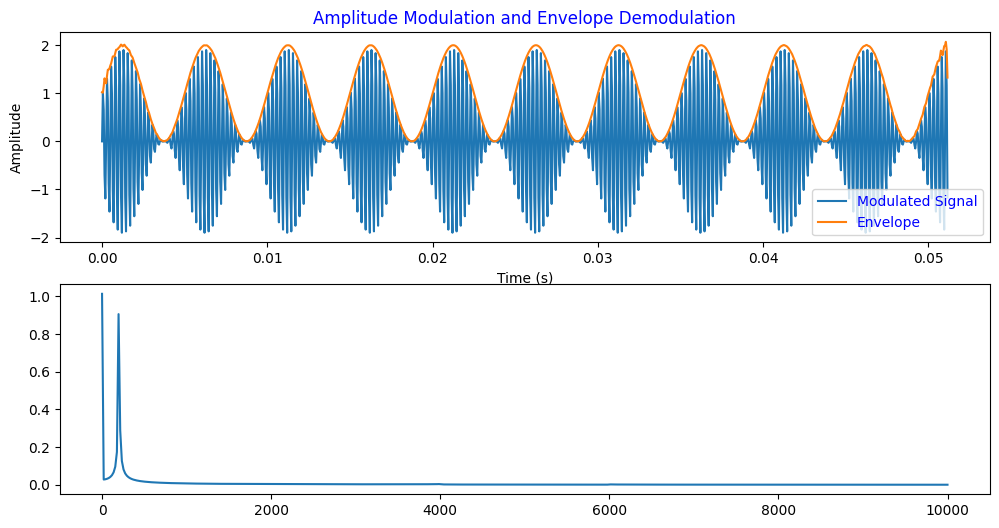

In [40]:

import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.signal import hilbert
from scipy import fftpack
from matplotlib import gridspec
def envelope_demodulation(signal, fs, N):
# """
#   require the input signal must use the column as the channel
# """

    # 计算信号的包络
    ht = fftpack.hilbert(signal)
    # xt = signal
    # envelope = np.abs(ht**2)
    envelope = np.abs(hilbert(signal))

    # 计算包络的频谱
    envelope_spectrum_ = (1/N)*np.abs(np.fft.fft(envelope))
    spectrum_ = (1/N)*np.abs(np.fft.fft(signal))
    f = (fs/N)*np.arange(N/2+1)
    frequency = f
    # frequency = np.fft.fftfreq(len(envelope), d=1.0)

    envelope_spectrum = 2*envelope_spectrum_[0:int(N/2)+1]
    envelope_spectrum[0] = envelope_spectrum_[0]
    envelope_spectrum[-1] = envelope_spectrum_[int(N/2)]

    spectrum = 2*spectrum_[0:int(N/2)+1]
    spectrum[0] = spectrum_[0]
    spectrum[-1] = spectrum_[int(N/2)]
    return envelope, frequency, spectrum, envelope_spectrum

# generating
fs = 20000  # 采样率
# t = np.linspace(0, 1, fs, endpoint=False)  # 时间向量
t1 = np.linspace(0, 1, fs, endpoint=False)
carrier_freq = 4000  # 载波频率
modulating_freq = 200  # 调制信号频率
amplitude = 1  # 调制深度
N = 1024
t = t1[0:N]
carrier_signal = amplitude * np.sin(2 * np.pi * carrier_freq * t)
modulating_signal = np.sin(2 * np.pi * modulating_freq * t)
modulated_signal = (1 + modulating_signal) * carrier_signal
# modulated_signal = teb_in[0,0,:]


envelope, frequency, spectrum, envelope_spectrum = envelope_demodulation(modulated_signal,fs,N)

plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(2, 1)
plt.subplot(gs[0,0])

plt.plot(t, modulated_signal, label='Modulated Signal')
plt.plot(t, envelope, label='Envelope')
plt.title('Amplitude Modulation and Envelope Demodulation')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.subplot(gs[1,0])
# plt.plot(frequency, modulated_signal, label='Modulated Signal')
plt.plot(frequency, envelope_spectrum, label='Envelope')


plt.show()


####input the polluted data and then use the proposed controlled data synthesizing method to generate the healthy samples

In [96]:
def p_sample_(model, x, y, t, betas, one_minus_alphas_bar_sqrt, w=3.0):
    """从x[T]采样t时刻的重构值"""
    batch_size = x.shape[0]
    device = next(model.parameters()).device
    t = torch.tensor([t]).cuda()
    t_ = t*torch.ones(batch_size,1).type(torch.int).cuda()
    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]
    # x = x.unsqueeze(dim = 1)
    # eps_theta = model(x, t_)
    eps_theta = (w+1)*model(x,t_,y,uncon_rate = 0.0) - w*model(x,t_,uncon_rate = 1.0)
    # eps_theta = model(x)
    #得到均值
    mean = (1 / (1 - betas[t]).sqrt()) * (x - (coeff * eps_theta))

    z = torch.randn_like(x)
    sigma_t = betas[t].sqrt()
    #得到sample的分布,使用了重参数技巧
    sample = mean + sigma_t * z

    return (sample)
# 从xt回复x0
def p_sample_loop_(model,x,y,n_steps,betas,one_minus_alphas_bar_sqrt):
    """从x[T]恢复x[T-1]、x[T-2]|...x[0]"""
    # cur_x = torch.randn(shape)
    cur_x = x
    cur_x = cur_x.cuda()
    betas = betas.cuda()
    one_minus_alphas_bar_sqrt = one_minus_alphas_bar_sqrt.cuda()
    # x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample_(model, cur_x, y, i, betas, one_minus_alphas_bar_sqrt,w=3.0)
        # x_seq.append(cur_x)
    return cur_x

<ipython-input-14-01dfdaa51387>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y,dtype=torch.int).view(-1,1).cuda()


(0.0, 1.0)

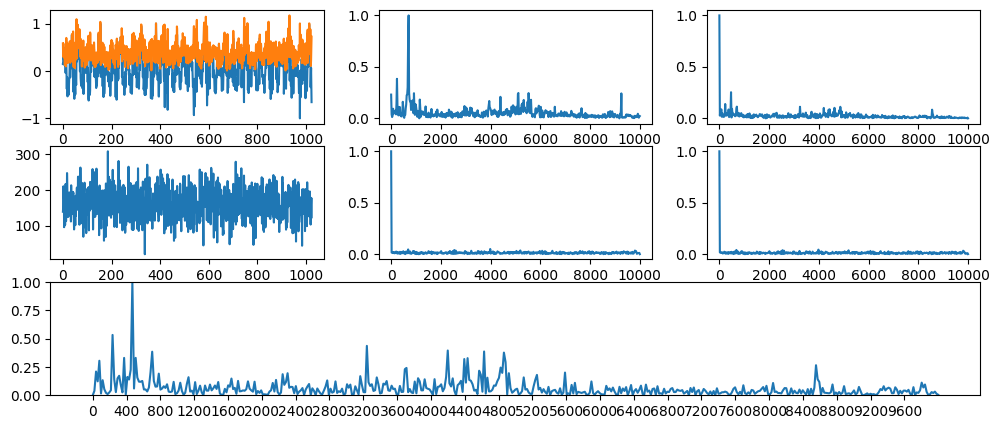

In [97]:
from scipy.interpolate import interp1d
model = torch.load('AE_Diffusion/Diff_model_ims7/ model_IMSDP_2200.pth')
model = model.eval()
# teb_in_h = healthy_sample[0:1,:,:]
# teb_out_h = q_x(teb_in_h,num_steps-1)
teb_in_h = b_in
teb_out_h = b_out
# g_out = b_out
g_in = b_in[0,1:2,:].detach().cpu().numpy()

from matplotlib import gridspec
with torch.no_grad():
  hl = torch.zeros(teb_in_h.shape[0]).cuda()
  # g_in = teb_in_h[0,1:2,:].detach().cpu().numpy()
  tegen_data= p_sample_loop_(model,teb_out_h,hl,num_steps,betas,one_minus_alphas_bar_sqrt)
# tegen_data = p_sample_loop_()
g_out = tegen_data[0,1:2,:].detach().cpu().numpy()
max_g = 1
min_g = -1
g_in = g_in*(max_g - min_g) + min_g
g_out = g_out*(max_g - min_g) + min_g

fs = 20000
envelope_out, frequency_out, spectrum_out, envelope_spectrum_out = envelope_demodulation(g_out.reshape(-1), fs, N)
envelope_in, frequency_in, spectrum_in, envelope_spectrum_in = envelope_demodulation(g_in.reshape(-1), fs, N)
spectrum_out = normalize(spectrum_out)
spectrum_in = normalize(spectrum_in)
envelope_spectrum_out = normalize(envelope_spectrum_out)
envelope_spectrum_in = normalize(envelope_spectrum_in)
# g11 = (1/N)*np.abs(np.fft.fft(g_in.reshape(-1)))
# g11_ = g11[1:int(N/2)+1]
# g22 = (1/N)*np.abs(np.fft.fft(g_out.reshape(-1)))
# g22_ = g22[1:int(N/2)+1]

anomaly_map = normalize(np.abs(envelope_spectrum_out-envelope_spectrum_in))
#anomaly_map = np.abs(g11_-g22_)
custom_xticks = np.arange(0, 10000, 400)


plt.figure(figsize = (12,5))
gs = gridspec.GridSpec(3, 3)
plt.subplot(gs[0,0])
plt.plot(g_in.reshape(-1))
plt.plot(envelope_in.reshape(-1))
plt.subplot(gs[0,1])
plt.plot(frequency_out,spectrum_in.reshape(-1))
plt.subplot(gs[0,2])
plt.plot(frequency_out,envelope_spectrum_in.reshape(-1))
plt.subplot(gs[1,0])
plt.plot(g_out.reshape(-1))
# plt.plot(envelope_out.reshape(-1))
plt.subplot(gs[1,1])
plt.plot(frequency_out,spectrum_out.reshape(-1))
plt.subplot(gs[1,2])
plt.plot(frequency_out,envelope_spectrum_out.reshape(-1))
plt.subplot(gs[2,:])
plt.plot(frequency_out,anomaly_map.reshape(-1))
plt.xticks(custom_xticks)
plt.ylim(0,1)

In [101]:
# import numpy as np
# import matplotlib.pyplot as plt

# # 生成示例信号
# fs = 1000  # 采样率
# t = np.arange(0, 1, 1/fs)  # 时间数组
# signal = np.sin(2 * np.pi * 50 * t) + 0.5 * np.sin(2 * np.pi * 200 * t)  # 含有50Hz和200Hz成分的信号

# # 进行FFT
# fft_result = np.fft.fft(signal)
# frequencies = np.fft.fftfreq(len(fft_result), 1/fs)

# # 定义带通滤波器
# def bandpass_filter(frequencies, low_cutoff, high_cutoff):
#     filter = np.ones_like(frequencies)
#     filter[(frequencies < low_cutoff) | (frequencies > high_cutoff)] = 0
#     return filter

# # 设置带通滤波器的截止频率
# low_cutoff = 40  # 低通滤波截止频率
# high_cutoff = 60  # 高通滤波截止频率

# # 应用带通滤波器
# filter = bandpass_filter(frequencies, low_cutoff, high_cutoff)
# filtered_fft = fft_result * filter

# # 进行逆FFT
# filtered_signal = np.fft.ifft(filtered_fft)

# # 绘制结果
# plt.figure(figsize=(12, 6))

# plt.subplot(3, 1, 1)
# plt.plot(t, signal)
# plt.title('原始信号')

# plt.subplot(3, 1, 2)
# plt.plot(frequencies, np.abs(fft_result))
# plt.title('频谱图')

# plt.subplot(3, 1, 3)
# plt.plot(t, np.real(filtered_signal))
# plt.title('带通滤波后的信号')

# plt.tight_layout()
# plt.show()

In [ ]:
from scipy.interpolate import interp1d
model = torch.load('AE_Diffusion/Diff_model_ims7/ model_IMSDP_2200.pth')
model = model.eval()
# teb_in_h = healthy_sample[0:1,:,:]
# teb_out_h = q_x(teb_in_h,num_steps-1)

teb_in_h = b_in
teb_out_h = b_out
# g_out = b_out
g_in = data_l[:,1:2,:]

from matplotlib import gridspec
with torch.no_grad():
  hl = torch.zeros(teb_in_h.shape[0]).cuda()
  # g_in = teb_in_h[0,1:2,:].detach().cpu().numpy()
  tegen_data= p_sample_loop_(model,teb_out_h,hl,num_steps,betas,one_minus_alphas_bar_sqrt)
# tegen_data = p_sample_loop_()
g_out = tegen_data[0,1:2,:].detach().cpu().numpy()
max_g = 1
min_g = -1
g_in = g_in*(max_g - min_g) + min_g
g_out = g_out*(max_g - min_g) + min_g

fs = 20000
envelope_out, frequency_out, spectrum_out, envelope_spectrum_out = envelope_demodulation(g_out.reshape(-1), fs, N)
envelope_in, frequency_in, spectrum_in, envelope_spectrum_in = envelope_demodulation(g_in.reshape(-1), fs, N)
spectrum_out = normalize(spectrum_out)
spectrum_in = normalize(spectrum_in)
envelope_spectrum_out = normalize(envelope_spectrum_out)
envelope_spectrum_in = normalize(envelope_spectrum_in)
# g11 = (1/N)*np.abs(np.fft.fft(g_in.reshape(-1)))
# g11_ = g11[1:int(N/2)+1]
# g22 = (1/N)*np.abs(np.fft.fft(g_out.reshape(-1)))
# g22_ = g22[1:int(N/2)+1]

anomaly_map = normalize(np.abs(envelope_spectrum_out-envelope_spectrum_in))

In [110]:
from scipy.interpolate import interp1d
model = torch.load('AE_Diffusion/Diff_model_ims7/ model_IMSDP_2200.pth')
model = model.eval()
teb_in_t = torch.tensor(data_1,dtype = torch.float32).cuda()
teb_out_t = q_x(teb_in_t,num_steps-1)
teb_ = teb_out_t.detach().cpu().numpy()
N = 1024
fs = 20000
with torch.no_grad():
  hl = torch.zeros(teb_.shape[0]).cuda()
  # g_in = teb_in_h[0,:,:].detach().cpu().numpy()
  tegen_data= p_sample_loop_(model,teb_out_t,hl,num_steps,betas,one_minus_alphas_bar_sqrt)
tegen_data_ef = np.zeros((4920,4,513))
tegen_data_ef_ori = np.zeros((4920,4,513))



<ipython-input-14-01dfdaa51387>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y,dtype=torch.int).view(-1,1).cuda()
<ipython-input-14-01dfdaa51387>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y,dtype=torch.int).view(-1,1).cuda()
<ipython-input-14-01dfdaa51387>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y,dtype=torch.int).view(-1,1).cuda()
<ipython-input-14-01dfdaa51387>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detac

NameError: name 'data_l' is not defined

In [111]:
for i in range(4920):
  for j in range(4):
    ori = data_1[i,j,:]
    temp = normalize(tegen_data[i,j,:].detach().cpu().numpy())
    max_g = 1
    min_g = -1
    temp = temp*(max_g - min_g) + min_g
    temp_ori = ori*(max_g - min_g) + min_g
    _1,_2,_3,temp_ef = envelope_demodulation(temp, fs, N)
    _1,_2,_3,temp_ef_ori = envelope_demodulation(temp_ori, fs, N)
    tegen_data_ef[i,j,:] = normalize(temp_ef)
    tegen_data_ef_ori[i,j,:] = normalize(temp_ef_ori)
# tegen_data = p_sample_loop_()
HI_AM = np.zeros((4920,4))
HI_AM = np.abs(tegen_data_ef[:,:,12]-tegen_data_ef_ori[:,:,12])




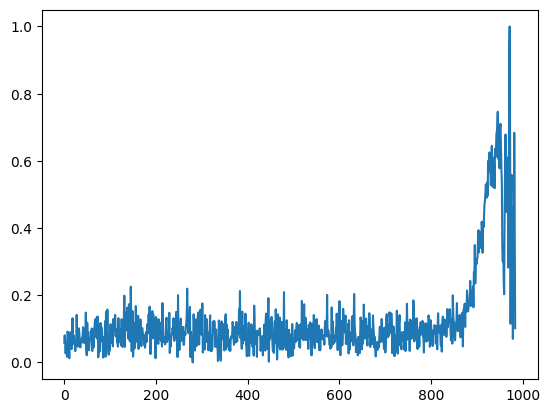

In [116]:
HI_AM_ = np.mean(HI_AM,axis = 1)
HI_t = np.ones(984)
for i in range(984):
  HI_t[i] = np.mean(HI_AM_[5*i:5*(i+1)])
HI_t = normalize(HI_t)
plt.plot(HI_t)
#HI_AM = np.abs(tegen_data_ef[:,:,12]-tegen_data_ef[0:1,:,12])

It's really a great pity that the hilbert transform is not efficient under thid circumstance because the frequency resolution is extremely low, even lower than the modulated frequency. So we have to use the frequency domain as a health indicator.

In [ ]:
import scipy.io as scio
scio.savemat('AE_Diffusion/AE_data_ims/result_2800.mat',{'g_in':g_in,'g_out':g_out})


In [118]:
import scipy.io as scio
scio.savemat('AE_Diffusion/AE_data_ims/result_2800_IMS.mat',{'g_in':g_in,'g_out':g_out})


In [ ]:
frequency_out[1]

156.25

In [ ]:
20000/256


78.125